Numerical experiment: Deep hedging as a risk-sensitive RL case study

In [ ]:
device = "cuda"

Risk aversion is modelled by an exponential utility parameter
$\lambda>0$.
$\lambda$ is sampled from a fixed interval
(e.g.\ $\lambda\in[10^{-4},1]$) at the beginning of each episode and is
treated as an additional input feature. Thus both policy and value
networks condition on $(\phi_t,\lambda)$.

In [138]:
import torch

LOG_LAM_MIN = torch.log(torch.tensor(1e-4))
LOG_LAM_MAX = torch.log(torch.tensor(1.0))

LAM_LOG_MEAN = -4.605170186
LAM_LOG_STD  =  2.659260036

def sample_lambda_features(batch_size, device):
    # sample log(lambda) uniform
    lam_log = torch.empty(batch_size, device=device).uniform_(LOG_LAM_MIN, LOG_LAM_MAX)

    lam = lam_log.exp()

    # feature
    lam_feature = (lam_log - LAM_LOG_MEAN) / LAM_LOG_STD

    return lam, lam_feature

Market dynamics

We consider a single risky asset $(S_t)_{t\in[0,T]}$ following a
stochastic volatility model of Heston type under a risk-neutral
measure:
\begin{align*}
  \mathrm{d}S_t &= \mu S_t \,\mathrm{d}t + \sqrt{v_t}\, S_t \,\mathrm{d}B_t,\\
  \mathrm{d}v_t &= \kappa(\theta - v_t)\,\mathrm{d}t + \xi \sqrt{v_t}\,\mathrm{d}W_t,
\end{align*}
where $B$ and $W$ are Brownian motions with correlation
$\mathrm{corr}(B,W) = \rho$, $\mu$ is the drift of the asset (taken
close to zero in the numerical experiments so that the problem is
primarily one of hedging rather than speculative trading), and
$(\kappa,\theta,\xi)$ are the mean reversion, long-run variance and
volatility-of-volatility parameters of the variance process.

In [139]:
from dataclasses import dataclass
from typing import Tuple, Optional
import numpy as np


Array = np.ndarray


@dataclass
class HestonParams:
    kappa: float  # mean reversion speed
    theta: float  # long-run variance
    xi: float     # vol of vol
    rho: float    # correlation between dB and dW
    mu: float = 0.0  # drift of the asset (set 0.0 under Q)


def _safe_sqrt(x: Array) -> Array:
    return np.sqrt(np.maximum(x, 0.0))


def simulate_heston_qe(n_paths: int, n_steps: int, dt: float, S0: float, v0: float, params: HestonParams, seed: Optional[int] = None, return_variance: bool = True,) -> Tuple[Array, Array] | Tuple[Array, None]:
    kappa, theta, xi, rho, mu = (params.kappa, params.theta, params.xi, params.rho, params.mu)
    rng = np.random.default_rng(seed)
    S = np.empty((n_paths, n_steps + 1), dtype=np.float64)
    S[:, 0] = S0
    v = np.empty((n_paths, n_steps + 1), dtype=np.float64) if return_variance else None
    if return_variance:
        v[:, 0] = v0
    v_t = np.full(n_paths, v0, dtype=np.float64)
    S_t = np.full(n_paths, S0, dtype=np.float64)
    eps = 1e-12
    exp_kdt = np.exp(-kappa * dt)
    for t in range(n_steps):
        m = theta + (v_t - theta) * exp_kdt
        s2 = (v_t * xi * xi * exp_kdt * (1 - exp_kdt) / kappa + theta * xi * xi * (1 - exp_kdt) ** 2 / (2 * kappa))
        psi = s2 / (m * m + eps)
        psi_c = 1.5
        v_next = np.empty_like(v_t)
        idx1 = psi <= psi_c
        if np.any(idx1):
            b2 = 2.0 / psi[idx1] - 1.0 + np.sqrt(2.0 / psi[idx1]) * np.sqrt(
                2.0 / psi[idx1] - 1.0
            )
            a = m[idx1] / (1.0 + b2)
            Z = rng.standard_normal(np.count_nonzero(idx1))
            v_next[idx1] = a * (Z + np.sqrt(b2)) ** 2
        idx2 = ~idx1
        if np.any(idx2):
            p = (psi[idx2] - 1.0) / (psi[idx2] + 1.0)
            beta = (1.0 - p) / m[idx2]
            U = rng.random(np.count_nonzero(idx2))
            v_next[idx2] = np.where(U > p, -np.log((1.0 - U) / (1.0 - p)) / beta, 0.0)
        Z1 = rng.standard_normal(n_paths)
        Z2 = rng.standard_normal(n_paths)
        dW1 = Z1 * _safe_sqrt(dt)
        dW2 = (rho * Z1 + np.sqrt(1.0 - rho * rho) * Z2) * _safe_sqrt(dt)
        vol_t = _safe_sqrt(np.maximum(v_t, 0.0))
        S_t = S_t * np.exp((mu - 0.5 * v_t) * dt + vol_t * dW1)
        v_t = np.maximum(v_next, eps)
        S[:, t + 1] = S_t
        if return_variance:
            v[:, t + 1] = v_t
    return (S, v) if return_variance else (S, None)

In [140]:
#def simulate_strik(datasize):
    #return np.random.uniform(0.9, 1.1, size=datasize)
    #return np.full(datasize, 1.0)

In [141]:
Ks = np.linspace(0.9, 1.1, 9).astype(np.float32)

In [142]:
K_mean = Ks.mean()
K_std  = Ks.std()

In [143]:
K_mean_t = torch.tensor(K_mean, dtype=torch.float32, device=device).detach()
K_std_t  = torch.tensor(K_std,  dtype=torch.float32, device=device).detach()

MDP state, features and risk aversion

The underlying Markov state is
\[
  s_t = (m_t,z_t),
\]
where $m_t$ collects the current market information  and $z_t$ encodes the current portfolio
(short option position and hedge position $\delta_{t-1}$).

Following the deep hedging setup of Murray et al.\ (2022), the agent
does not observe $(S_t,v_t)$ directly but uses a fixed
\emph{linear Markov representation} (LMR) of the portfolio. Concretely,
for each time step we compute a feature vector
$\phi_t = \Phi_t(s_t)\in\R^d$ consisting of the Black--Scholes price of
the portfolio and a set of Greeks with respect to the underlyer and
volatility (delta, gamma, vega, theta and higher-order sensitivities),
together with time-to-maturity and strike information. This gives a
low-dimensional, Markovian feature representation of the state which is
used as input to the neural networks.

Helpers to extract the the features needed in step functions of environment

In [144]:
import torch
from torch.distributions.normal import Normal


Tensor = torch.Tensor
_EPS = 1e-12


_normal_dist = Normal(torch.tensor(0.0), torch.tensor(1.0))


@dataclass(frozen=True)
class LMRPack:
    features: Tensor  # shape (..., 9)
    book_value: Tensor  # shape (...,)
    delta_bs_target: Tensor  # h*_BS
    strike: Tensor


@dataclass(frozen=True)
class BSCallResult:
    price: Tensor
    delta: Tensor
    gamma: Tensor
    vega: Tensor
    theta: Tensor


def bs_call_torch(S: Tensor, K: Tensor, tau: Tensor, sigma: Tensor) -> BSCallResult:
    tau = torch.clamp(tau, min=_EPS)
    sigma = torch.clamp(sigma, min=_EPS)
    sigma_sqrt_tau = sigma * torch.sqrt(tau)
    d1 = (torch.log(S / K) + 0.5 * (sigma**2) * tau) / sigma_sqrt_tau
    d2 = d1 - sigma_sqrt_tau
    n_d1_pdf = _normal_dist.log_prob(d1).exp()
    n_d2_cdf = _normal_dist.cdf(d2)
    n_d1_cdf = _normal_dist.cdf(d1)
    price = S * n_d1_cdf - K * n_d2_cdf
    delta = n_d1_cdf
    gamma = n_d1_pdf / (S * sigma_sqrt_tau)
    vega = S * n_d1_pdf * torch.sqrt(tau)
    theta = -(S * n_d1_pdf * sigma) / (2 * torch.sqrt(tau))
    return BSCallResult(price=price.detach(), delta=delta.detach(), gamma=gamma.detach(), vega=vega.detach(), theta=theta.detach())


def lmr_call_short_torch(S: Tensor, v: Tensor, K: Tensor | float, tau: Tensor | float, hedge_pos: Tensor | float, notional: float = 100.0,) -> LMRPack:
    device, dtype = S.device, S.dtype
    #S = torch.as_tensor(S, device=device, dtype=dtype).detach()
    #v = torch.as_tensor(v, device=device, dtype=dtype).detach()
    #K = torch.as_tensor(K, device=device, dtype=dtype).detach()
    tau = torch.as_tensor(tau, device=device, dtype=dtype).detach()
    #h = torch.as_tensor(hedge_pos, device=device, dtype=dtype)
    sigma = torch.sqrt(torch.clamp(v, min=_EPS)).detach()
    call = bs_call_torch(S.detach(), K.detach(), tau.detach(), sigma.detach())
    B = -notional * call.price.detach() + hedge_pos * S.detach()
    #log_moneyness = torch.log(S.detach()/K.detach())
    feats = torch.stack([
            # B,
            -notional * call.delta.detach() + hedge_pos,
            -notional * call.gamma.detach(),
            -notional * call.vega.detach(),
            -notional * call.theta.detach(),
            # -notional * call.vanna.detach(),
            # -notional * call.charm.detach(),
            # -notional * call.vomma.detach(),
            #K.expand_as(B).detach(),
            tau.expand_as(B).detach(),
            # v
            #log_moneyness.detach(),
            #hedge_pos,
        ],dim=-1,)
    delta_bs_target = notional * call.delta.detach()  # target hedge in shares under BS
    return LMRPack(features=feats, book_value=B, delta_bs_target=delta_bs_target, strike=K.detach(),)


def txn_cost_torch(alpha: float, hedge_old: Tensor, hedge_new: Tensor, S: Tensor) -> Tensor:
    return torch.abs(hedge_new - hedge_old) * S * float(alpha)

At $t=0$ the agent is short a European call option on $S$ with strike
$K$ and maturity $T$, with payoff
\begin{equation}
  \Pi^{\mathrm{opt}} = -N (S_T - K)_+,\nonumber
\end{equation}
for a fixed notional $N>0$. The only traded hedging instrument is the
underlying asset $S$; no static hedges or additional derivatives are
used. Let $\delta_t$ denote the number of units of $S$ held after
trading at time $t$. The control variable is the change in hedge
position
\begin{equation}
  a_t := \delta_t - \delta_{t-1}, \qquad t=0,\dots,T-1,\nonumber
\end{equation}
with $\delta_{-1}=0$.

Trading incurs proportional transaction costs: a trade $a_t$ at price
$S_t$ leads to costs
\begin{equation}
  \mathrm{TC}_t = \alpha\, |a_t|\, S_t,\nonumber
\end{equation}
with fixed cost coefficient $\alpha>0$. The one-step reward is defined
as incremental portfolio cash flow,
\begin{equation}
  r_t =
  \begin{cases}
    - a_t S_t - \mathrm{TC}_t, & t = 0,\dots,T-1,\\[0.3em]\nonumber
    \delta_{T-1} S_T - \Pi^{\mathrm{opt}}, & t = T,
  \end{cases}
\end{equation}
so that the total return $R_0^\pi = \sum_{t=0}^T r_t$ equals the
terminal hedged P\&L of the short option position under policy $\pi$.

The step and reward functions

In [145]:
from typing import Dict, List


Tensor = torch.Tensor


@dataclass
class EnvConfig:
    T_steps: int = 30
    dt_years: float = 1/252
    S0: float = 1.0
    v0: float = 0.00625
    notional: float = 100.0
    alpha: float = 0.002
    h_max: float = 100.0


class HedgingEnvTorch:
    def __init__(self, cfg: EnvConfig, sample_S: np.ndarray, sample_v: np.ndarray, sample_K: np.ndarray, device: str = device):
        self.cfg = cfg
        self.device = torch.device(device)
        self.sample_S_np = sample_S
        self.sample_v_np = sample_v
        self.sample_K_np = sample_K
        self._rng = np.random.default_rng()
        self.S: Optional[torch.Tensor] = None
        self.v: Optional[torch.Tensor] = None
        self.K: Optional[torch.Tensor] = None
        self.h: Optional[torch.Tensor] = None
        self.t: int = 0
        self.n_paths: int = 0


    def reset(self, n_paths: int) -> Dict[str, torch.Tensor]:
        self.n_paths = n_paths
        N = self.sample_S_np.shape[0]
        idx = np.random.choice(N, size=n_paths, replace=False)
        S_np = self.sample_S_np[idx]
        v_np = self.sample_v_np[idx]
        K_np = self.sample_K_np[idx]
        self.S = torch.from_numpy(S_np).to(self.device, dtype=torch.float32)
        self.v = torch.from_numpy(v_np).to(self.device, dtype=torch.float32)
        self.K = torch.from_numpy(K_np).to(self.device, dtype=torch.float32)
        self.h = torch.zeros(n_paths, device=self.device, dtype=torch.float32)
        self.t = 0
        return self._obs()


    def _obs(self) -> Dict[str, torch.Tensor]:
        tau = (self.cfg.T_steps - self.t) * self.cfg.dt_years
        pack = lmr_call_short_torch(S=self.S[:, self.t].detach(), v=self.v[:, self.t].detach(), K=self.K.detach(), tau=tau, hedge_pos=self.h, notional=self.cfg.notional,)
        return {"features": pack.features, "book": pack.book_value, "delta_bs": pack.delta_bs_target, "strike": pack.strike,}


    def step(self, action: torch.Tensor) -> Tuple[Optional[Dict[str, torch.Tensor]], torch.Tensor, bool]:#, Dict]:
        if self.S is None:
            raise RuntimeError("Call reset() before step().")
        if self.t >= self.cfg.T_steps:
            raise RuntimeError("Episode already finished. Reset first.")
        h_new = action
        S_t = self.S[:, self.t].detach()
        h_old = self.h.detach()
        cost_t = txn_cost_torch(self.cfg.alpha, hedge_old=h_old, hedge_new=h_new, S=S_t)
        cashflow = (h_old - h_new) * S_t
        reward = cashflow - cost_t
        self.t += 1
        done = self.t >= self.cfg.T_steps
        #info = {"cashflow": cashflow, "cost": cost_t}
        if done:
            S_T = self.S[:, self.t].detach()
            payoff_option = -self.cfg.notional * torch.clamp(S_T - self.K.detach(), min=0.0)
            payoff_hedge = h_new * S_T
            cost_liq = txn_cost_torch(self.cfg.alpha, hedge_old=h_new, hedge_new=0.0, S=S_T)
            reward = reward + payoff_option + payoff_hedge - cost_liq
            #info.update({"payoff": payoff_option + payoff_hedge, "cost_liq": cost_liq})
            next_obs = None
        else:
            self.h = h_new
            next_obs = self._obs()
        return next_obs, reward, done#, info


def extract_scaling_algorithm_torch(environment: HedgingEnvTorch) -> Tuple[Tensor, Tensor]:
    a: List[Tensor] = []
    done = False
    n_paths_total = environment.sample_S_np.shape[0]
    obs = environment.reset(n_paths=n_paths_total)
    while not done:
        a.append(obs["features"])
        obs, _, done = environment.step(obs["delta_bs"])
    features = torch.cat(a, dim=0)
    return features.mean(dim=0), features.std(dim=0)


def transform_torch(X, mean, std):
    if not torch.is_tensor(X):
        X = torch.as_tensor(X, dtype=torch.float32)
    if not torch.is_tensor(mean):
        mean = torch.as_tensor(mean, dtype=X.dtype, device=X.device)
    if not torch.is_tensor(std):
        std  = torch.as_tensor(std,  dtype=X.dtype, device=X.device)

    return (X - mean) / (std + 1e-9)


In [146]:
import torch.nn as nn


class Critic(nn.Module):
    def __init__(self, d_in: int = 10, hidden: int = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden), nn.Sigmoid(),
            nn.Linear(hidden, hidden), nn.Sigmoid(),
            nn.Linear(hidden, hidden), nn.Sigmoid(),
            nn.Linear(hidden, 1)
        )
        nn.init.uniform_(self.net[-1].weight, -1e-3, 1e-3)
        nn.init.constant_(self.net[-1].bias, 0.0)


    def forward(self, x: torch.Tensor, book_value: torch.Tensor, lam: Tensor, strike: Tensor) -> torch.Tensor:
        value = book_value + self.net(torch.cat([x, lam, strike], dim=1)).squeeze(-1)
        return value

In [147]:
class Actor(nn.Module):
    def __init__(self, d_in: int = 10, hidden: int = 256, h_max: float = 100.0):
        super().__init__()
        self.h_max = h_max
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden), nn.Sigmoid(),
            nn.Linear(hidden, hidden), nn.Sigmoid(),
            nn.Linear(hidden, hidden), nn.Sigmoid(),
            nn.Linear(hidden, 1)
        )
        nn.init.uniform_(self.net[-1].weight, -1e-3, 1e-3)
        nn.init.constant_(self.net[-1].bias, 0.0)


    def forward(self, x: torch.Tensor, delta_bs: torch.Tensor, lam: Tensor, strike: Tensor) -> torch.Tensor:
        adj = self.net(torch.cat([x, lam, strike], dim=1)).squeeze(-1)
        raw = delta_bs + adj
        return raw#torch.clamp(raw, 0.0, self.h_max)

The risk-averse Actor-Critic Algorithm

In [148]:
import torch.optim as optim


def critic_loss(y_t, V_t, lam_t):
    diff = (y_t - V_t)
    return (torch.exp(-lam_t * diff) / lam_t - V_t).mean()



def soft_update(target: nn.Module, source: nn.Module, tau: float):
    with torch.no_grad():
        for p_t, p in zip(target.parameters(), source.parameters()):
            p_t.data.mul_(1 - tau).add_(tau * p.data)

#-------------------------------------------------------------------------------

class DeepBellmanTrainer:
    def __init__(self, env: HedgingEnvTorch, mean, std, device: str = device):
        self.device = torch.device(device)
        self.env = env
        self.actor = Actor(d_in=7, hidden=256, h_max=env.cfg.h_max).to(self.device)
        self.critic = Critic(d_in=7, hidden=256).to(self.device)
        self.critic_targ = Critic(d_in=7, hidden=256).to(self.device)
        self.critic_targ.load_state_dict(self.critic.state_dict())
        self.optA = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.optC = optim.Adam(self.critic.parameters(), lr=1e-4)
        self.tau = 0.001
        self.mean = torch.as_tensor(mean, dtype=torch.float32, device=self.device)
        self.std = torch.as_tensor(std, dtype=torch.float32, device=self.device)


    def train(self, episodes: int = 10_000, batch_size: int = 2048):
        stats = []
        for ep in range(1, episodes + 1):
            #lam = 0.6
            #lam_batch = np.full((batch_size, ), lam)
            #lam_batch = 10**np.random.uniform(-4, 0, size=(batch_size,))
            #lam = (0.1 + (0.9 - 0.1) * torch.rand(batch_size, device=self.device)).detach()
            #lam_u = lam.unsqueeze(-1).detach()
            #lam_norm = ((lam_u - lam_u.mean()) / lam_u.std()).detach()
            #lam_t = torch.as_tensor(lam, dtype=torch.float32, device=self.device).detach()
            #lam_norm = torch.as_tensor(lam_norm, dtype=torch.float32, device=self.device).detach()
            lam, lam_feature = sample_lambda_features(batch_size, self.device)
            lam_norm = lam_feature.unsqueeze(-1).detach()
            obs = self.env.reset(n_paths=batch_size)
            book = obs["book"]
            x = transform_torch(obs["features"], self.mean, self.std)
            strike = obs["strike"].detach()
            strike = transform_torch(obs["strike"], K_mean_t, K_std_t).unsqueeze(-1).detach()
            done = False
            total_reward = 0.0
            steps = 0
            sum_td_mean = 0.0
            sum_td_abs = 0.0
            sum_a_mean = 0.0
            sum_a_std = 0.0
            sum_gC = 0.0
            sum_gA = 0.0
            while not done:
                steps += 1
                delta_bs = obs["delta_bs"]


                #critic
                #----------------------------------------------------------------------------------
                #evaluate critic (WITHZ GRAD, but no grad fur inputs) at t
                V_t = self.critic(x.detach(), book.detach(), lam_norm.detach(), strike.detach())

                #choose action(with grad, but no grads for input)
                a_t = self.actor(x.detach(), delta_bs.detach(), lam_norm.detach(), strike.detach())

                a_det = a_t.detach()
                sum_a_mean += a_det.mean().item()
                sum_a_std += a_det.std().item()


                #get reward and make step(WITH GRAD)
                obs, r_t, done = self.env.step(a_t)

                #evaluate critic-target (has no grad) for t+1
                if not done:
                    x = transform_torch(obs["features"], self.mean.detach(), self.std.detach())
                    book = obs["book"]
                    with torch.no_grad():
                        V_next_target = self.critic_targ(x, book, lam_norm, strike)
                else:
                    V_next_target = torch.zeros_like(V_t)

                # critic target for t (has no grad)
                y_t = r_t.detach() + V_next_target

                #TD-Fehler
                diff = (y_t - V_t).detach()
                sum_td_mean += diff.mean().item()
                sum_td_abs += diff.abs().mean().item()
# ----------------------------

                #critic loss critic target at t vs critic eval at t
                lc = critic_loss(y_t.detach(), V_t, lam.detach())
                self.optC.zero_grad()
                lc.backward()
                gC = nn.utils.clip_grad_norm_(self.critic.parameters(), 10.0)
                sum_gC += float(gC)
                self.optC.step()

                #--------------------------------------------------------------------------------------------

                #actor
                #---------------------------------------------------------------------
                # future value of chosen action: to evaluate this, critic gets grad for actor weights BUT ALSO THE INPUTS to eval how chosen action might influence next state observations (greeks, and (imperfect) book value), which in return determine next_state_value/critic
                if not done:
                    V_next_for_actor = self.critic(x, book, lam_norm.detach(), strike.detach())
                else:
                    V_next_for_actor = torch.zeros_like(V_t)

                #actor loss
                y_actor_exponent = (-lam.detach() * (r_t + V_next_for_actor))
                la = (torch.exp(y_actor_exponent) / lam.detach()).mean()
                self.optA.zero_grad()
                la.backward()







                gA = nn.utils.clip_grad_norm_(self.actor.parameters(), 10.0)
                sum_gA += float(gA)
                self.optA.step()

            #-----------------------------------------------------------------------
                soft_update(self.critic_targ, self.critic, self.tau)
                total_reward += r_t.mean().item()

            if ep % 100 == 0:
                s = max(steps, 1)
                print(
        f"λ_mean={lam.mean().item():.4f}"
        f"CriticLoss={lc.item():8.4f} | ActorLoss={la.item():8.4f} | "
        f"R_total={total_reward:8.4f} | "
        f"TD_mean={sum_td_mean/s: .3e} | TD_abs={sum_td_abs/s: .3e} | "
        f"||g_C||={sum_gC/s: .3e} | ||g_A||={sum_gA/s: .3e} | "
        f"a_mean={sum_a_mean/s: .3f} | a_std={sum_a_std/s: .3f}"
    )


        print("Training complete.")
        return stats

In [149]:
datasize = 200000
time_to_maturiry = 30


params = HestonParams(kappa=8.0, theta=0.00625, xi=1.0, rho=-0.7, mu=0.0)
S, v = simulate_heston_qe(
    n_paths=datasize, n_steps=time_to_maturiry, dt=1/252,
    S0=1.0, v0=0.00625, params=params, seed=1
)
#K = simulate_strik(datasize)
K = np.random.choice(Ks, size=datasize).astype(np.float32)
cfg = EnvConfig(T_steps=time_to_maturiry)
environment_K = HedgingEnvTorch(cfg, S, v, K)


mean_for_scaling, std_for_scaling = extract_scaling_algorithm_torch(environment_K)

In [150]:
trainer = DeepBellmanTrainer(environment_K, mean_for_scaling, std_for_scaling)

trained for approx 3.5h on a GPU

In [151]:
#stats = trainer.train(episodes=40000, batch_size=2048)

In [152]:
'''
torch.save({
    "actor": trainer.actor.state_dict(),
    "critic": trainer.critic.state_dict(),
}, "checkpoint.pt")
'''

'\ntorch.save({\n    "actor": trainer.actor.state_dict(),\n    "critic": trainer.critic.state_dict(),\n}, "checkpoint.pt")\n'

In [153]:
checkpoint = torch.load("checkpoint.pt", map_location=torch.device(device))
trainer.actor.load_state_dict(checkpoint["actor"])
trainer.critic.load_state_dict(checkpoint["critic"])

<All keys matched successfully>

In [154]:
lam, lam_feat = sample_lambda_features(100000, device)

In [155]:
lam_norm = lam_feat.unsqueeze(-1).detach()

In [156]:
'''
obs = environment_K.reset(n_paths=100000)

X = transform_torch(obs["features"], mean_for_scaling, std_for_scaling)
delta_bs = obs["delta_bs"]
strike = transform_torch(obs["strike"], K_mean_t, K_std_t).unsqueeze(-1)

trainer.actor.eval()
with torch.no_grad():
    hedge = trainer.actor(X, delta_bs, lam_norm, strike)   # (N,)

hedge_np = hedge.cpu().numpy()


import matplotlib.pyplot as plt
plt.scatter(lam.cpu().numpy(), hedge_np, s=3, alpha=0.4)
plt.xlabel("Risk aversion")
plt.ylabel("hedge position")
plt.title("For all strikes seen in Training: ")
plt.show()
'''


'\nobs = environment_K.reset(n_paths=100000)\n\nX = transform_torch(obs["features"], mean_for_scaling, std_for_scaling)\ndelta_bs = obs["delta_bs"]\nstrike = transform_torch(obs["strike"], K_mean_t, K_std_t).unsqueeze(-1)\n\ntrainer.actor.eval()\nwith torch.no_grad():\n    hedge = trainer.actor(X, delta_bs, lam_norm, strike)   # (N,)\n\nhedge_np = hedge.cpu().numpy()\n\n\nimport matplotlib.pyplot as plt\nplt.scatter(lam.cpu().numpy(), hedge_np, s=3, alpha=0.4)\nplt.xlabel("Risk aversion")\nplt.ylabel("hedge position")\nplt.title("For all strikes seen in Training: ")\nplt.show()\n'

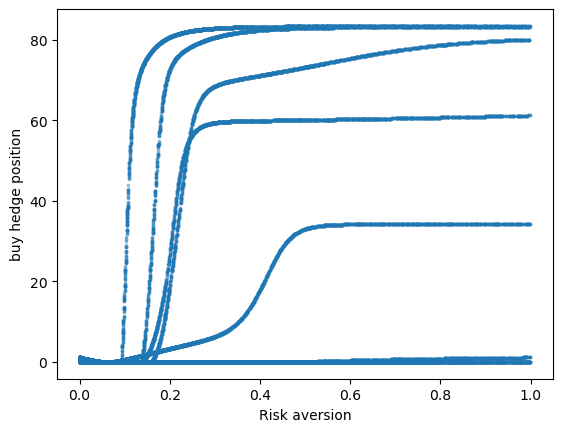

In [157]:
import matplotlib.pyplot as plt

obs = environment_K.reset(n_paths=100000)

X = transform_torch(obs["features"], mean_for_scaling, std_for_scaling)
delta_bs = obs["delta_bs"]
book = obs["book"]

strikes = transform_torch(obs["strike"], K_mean_t, K_std_t).unsqueeze(-1)
    

trainer.actor.eval()
with torch.no_grad():
    hedge = trainer.actor(X, delta_bs, lam_norm, strikes).clamp(0, 100)
    value = trainer.critic(X, book, lam_norm, strikes)   # (N,)

hedge_np = hedge.cpu().numpy()
'''
strikes = strikes.squeeze(-1).cpu().numpy()
step = 0
for i in Ks:
    strike_i = strikes == i
    plt.scatter(lam.cpu().numpy()[strike_i], hedge_np[strike_i], s=3, alpha=0.4, color=colors[step])
    stpe = step +1
'''

plt.scatter(lam.cpu().numpy(), hedge_np, s=3, alpha=0.4)
plt.xlabel("Risk aversion")
plt.ylabel("buy hedge position")
plt.show()

In [158]:
#K = np.random.choice(Ks, size=datasize).astype(np.float32)
K = np.random.uniform(0.7, 1.3, size=datasize)
environment_K = HedgingEnvTorch(cfg, S, v, K)

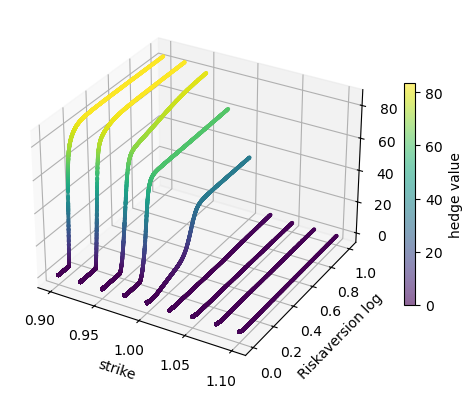

In [159]:
from mpl_toolkits.mplot3d import Axes3D  # noqa

lam_np = lam.cpu().numpy().flatten()
f4_np  = obs["strike"].cpu().numpy().flatten()
h_np   = hedge_np.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    f4_np,
    (lam_np),
    h_np,
    s=3,
    alpha=0.6,
    c=h_np,                 # Farbe nach hedge
    cmap='viridis',         # oder 'plasma', 'coolwarm', 'inferno', ...
)

ax.set_xlabel("strike")
ax.set_ylabel("Riskaversion log")
#ax.set_zlabel("hedgeposition")
#x.set_title("Initial hedge as a function of strike and risk aversion. The policy network smoothly interpolates from zero position for low λ to an almost full hedge for high λ.", pad=12)

# optional Farbleiste hinzufügen
fig.colorbar(sc, ax=ax, shrink=0.6, label="hedge value")

plt.show()

In [160]:
#K = np.random.choice(Ks, size=datasize).astype(np.float32)
K = np.random.uniform(0.7, 1.3, size=datasize)
environment_K = HedgingEnvTorch(cfg, S, v, K)

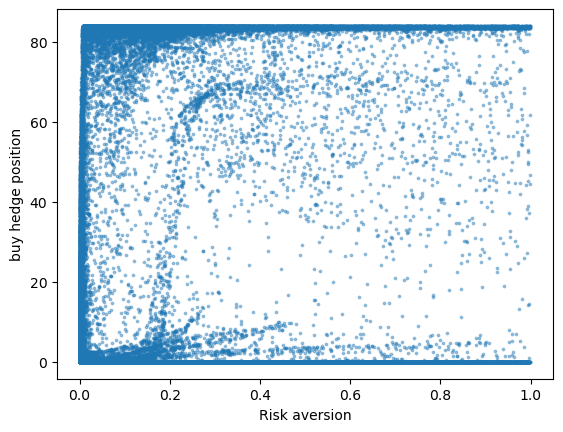

In [161]:
import matplotlib.pyplot as plt

obs = environment_K.reset(n_paths=100000)

X = transform_torch(obs["features"], mean_for_scaling, std_for_scaling)
delta_bs = obs["delta_bs"]
book = obs["book"]

strikes = transform_torch(obs["strike"], K_mean_t, K_std_t).unsqueeze(-1)
    

trainer.actor.eval()
with torch.no_grad():
    hedge = trainer.actor(X, delta_bs, lam_norm, strikes).clamp(0, 100)
    value = trainer.critic(X, book, lam_norm, strikes)   # (N,)

hedge_np = hedge.cpu().numpy()
'''
strikes = strikes.squeeze(-1).cpu().numpy()
step = 0
for i in Ks:
    strike_i = strikes == i
    plt.scatter(lam.cpu().numpy()[strike_i], hedge_np[strike_i], s=3, alpha=0.4, color=colors[step])
    stpe = step +1
'''

plt.scatter(lam.cpu().numpy(), hedge_np, s=3, alpha=0.4)
plt.xlabel("Risk aversion")
plt.ylabel("buy hedge position")
plt.show()

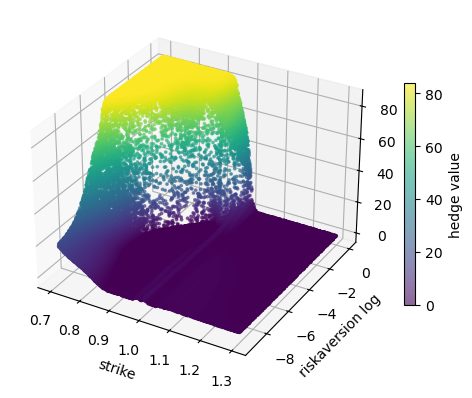

In [162]:
from mpl_toolkits.mplot3d import Axes3D  # noqa

lam_np = lam.cpu().numpy().flatten()
f4_np  = obs["strike"].cpu().numpy().flatten()
h_np   = hedge_np.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    f4_np,
    np.log(lam_np),
    h_np,
    s=3,
    alpha=0.6,
    c=h_np,                 # Farbe nach hedge
    cmap='viridis',         # oder 'plasma', 'coolwarm', 'inferno', ...
)

ax.set_xlabel("strike")
ax.set_ylabel("riskaversion log")
#ax.set_zlabel("hedgeposition")
#x.set_title("Initial hedge as a function of strike and risk aversion. The policy network smoothly interpolates from zero position for low λ to an almost full hedge for high λ.", pad=12)

# optional Farbleiste hinzufügen
fig.colorbar(sc, ax=ax, shrink=0.6, label="hedge value")

plt.show()

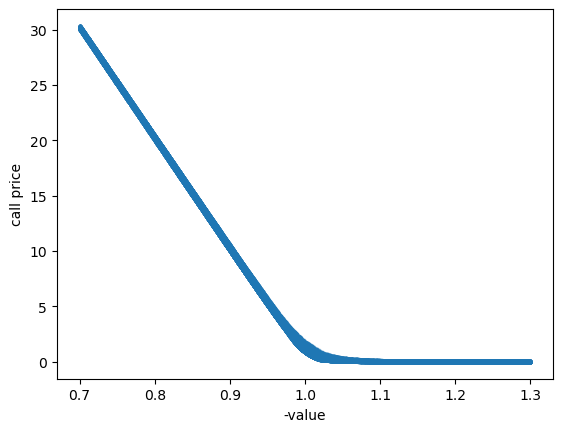

In [164]:
plt.scatter(f4_np, -value.cpu().numpy(), s=3, alpha=0.4)
plt.xlabel("-value")
plt.ylabel("call price")
#plt.title("Call prices obtained by the value function for maturity T = 30 compared with risk-neutral model prices. Low λ produces prices very close to the model price, and higher λ results in additional risk premium added.", pad=12)

plt.show()

In [165]:
s = 100000
K = np.full(datasize, 1.0)
environment_K = HedgingEnvTorch(cfg, S, v, K)

In [166]:
total_reward_unhedged = np.zeros(s)
obs = environment_K.reset(n_paths=s)
done = False
a_no = torch.zeros((s,), dtype=torch.float32, device=device)
while not done:
    obs, reward, done = environment_K.step(a_no)
    total_reward_unhedged += reward.cpu().numpy()

In [167]:
total = []


for l in [0.001, 0.01, 0.1, 1.0]:
    total_reward = np.zeros(s)
    lam = torch.log(torch.ones((100000,), dtype=torch.float32, device=device) * l)
    lam_feature = (lam - LAM_LOG_MEAN) / LAM_LOG_STD
    lam_norm = lam_feat.unsqueeze(-1).detach()
    obs = environment_K.reset(n_paths=s)
    done = False
    while not done:
        X = transform_torch(obs["features"], mean_for_scaling, std_for_scaling)
        delta_bs = obs["delta_bs"]
        strike = transform_torch(obs["strike"], K_mean_t, K_std_t).unsqueeze(-1)
        trainer.actor.eval()
        with torch.no_grad():
            hedge = trainer.actor(X, delta_bs, lam_norm, strike)   # (N,)
        obs, reward, done = environment_K.step(hedge)
        total_reward += reward.cpu().numpy()
    total.append(total_reward)

In [168]:
total_0001 = total[0]
total_001 = total[1]
total01 = total[2]
total1 = total[3]

In [169]:
for i in range(len(total)):
    print(total[i].std())

1.4208056909368318
1.4164732308388794
1.3950234076991224
1.418275024584911


In [170]:
total_reward_unhedged.std()

1.759210083190525

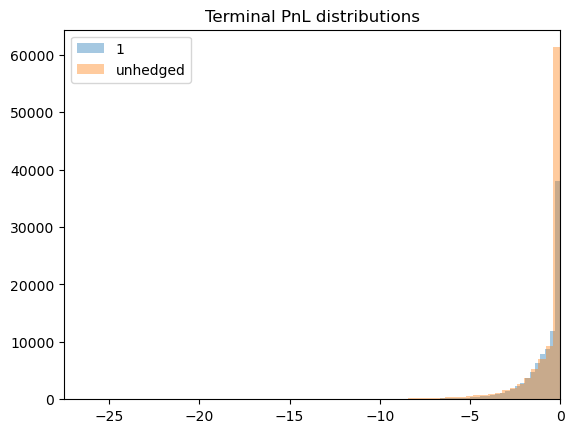

In [171]:
#plt.hist(total_0001, bins=80, alpha=0.4, label='0001')
#plt.hist(total_001, bins=80, alpha=0.4, label='001')
#plt.hist(total01, bins=80, alpha=0.4, label='01')
plt.hist(total1, bins=80, alpha=0.4, label='1')
plt.hist(total_reward_unhedged, bins = 80, alpha = 0.4, label = 'unhedged')
plt.legend()
plt.xlim(-27.5, 0)
plt.title("Terminal PnL distributions")
plt.show()

In [172]:
K_eval = [0.9, 0.95, 1.0, 1.05, 1.1]

In [173]:
total_actor_critic = []
total_BS = []



for k in K_eval:
    K = np.full(datasize, k)
    environment_K = HedgingEnvTorch(cfg, S, v, K)
    environment_BS = HedgingEnvTorch(cfg, S, v, K)
    total_reward = np.zeros(s)
    total_reward_BS = np.zeros(s)
    lam = torch.log(torch.ones((100000,), dtype=torch.float32, device=device) * 0.1)
    lam_feature = (lam - LAM_LOG_MEAN) / LAM_LOG_STD
    lam_norm = lam_feat.unsqueeze(-1).detach()
    obs = environment_K.reset(n_paths=s)
    obs_BS = environment_BS.reset(n_paths=s)
    done = False
    while not done:
        X = transform_torch(obs["features"], mean_for_scaling, std_for_scaling)
        delta_bs = obs["delta_bs"]
        strike = transform_torch(obs["strike"], K_mean_t, K_std_t).unsqueeze(-1)
        trainer.actor.eval()
        with torch.no_grad():
            hedge = trainer.actor(X, delta_bs, lam_norm, strike)   # (N,)
        obs, reward,_ = environment_K.step(hedge)
        obs_BS, reward_BS, done = environment_BS.step(delta_bs)
        total_reward += reward.cpu().numpy()
        total_reward_BS += reward_BS.cpu().numpy()
    total_actor_critic.append(total_reward)
    total_BS.append(total_reward_BS)

In [174]:
def utility(X, lam):
    return -(np.log(np.mean(np.exp(-lam * X))))/ lam

In [175]:
for i in range(len(K_eval)):
    strike = K_eval[i]
    utility_ac = utility(total_actor_critic[i], 0.1)
    utility_bs = utility(total_BS[i], 0.1)
    print(strike, utility_ac, utility_bs)

0.9 -10.525531542988404 -10.429447834513343
0.95 -5.490627925562028 -5.58297052164282
1.0 -1.1151925583815208 -1.6152381803551707
1.05 -0.14956855744730635 -0.24745370820427043
1.1 -0.04656259950157759 -0.05020611515002879
